In [23]:
import pandas 
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models, layers,regularizers
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import norm, rankdata
from sklearn.metrics import roc_auc_score


In [3]:
def add_columns(df):
    for col in df.columns:
        # Normalize the data, so that it can be used in norm.cdf(), as though it is a standard normal variable
        df[col] = ((df[col] - df[col].mean()) / df[col].std()).astype('float32')

        # Square
        df[col+'_s'] = df[col] * df[col]

        # Cube
        df[col+'_c'] = df[col] * df[col] * df[col]

        # 4th power
        df[col+'_q'] = df[col] * df[col] * df[col] * df[col]

        # Cumulative percentile (not normalized)
        df[col+'_r'] = rankdata(df[col]).astype('float32')

        # Cumulative normal percentile
        df[col+'_n'] = norm.cdf(df[col]).astype('float32')
    for col in df.columns:
        df[col] = ((df[col] - df[col].mean()) / df[col].std()).astype('float32')


In [4]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [5]:

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


In [3]:
# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#         pt_1 = K.clip(pt_1, 1e-3, .999)
#         pt_0 = K.clip(pt_0, 1e-3, .999)

#         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [6]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [7]:
train_path = '../input/train.csv'
train = pandas.read_csv(train_path)

test_path = '../input/test.csv'
test = pandas.read_csv(test_path)

target = train.target
train = train.drop('target',axis = 1)
ID_code = train.ID_code
train = train.drop('ID_code',axis=1)

ID_code = test.ID_code
test = test.drop('ID_code',axis=1)

In [8]:
train.shape

(200000, 200)

In [9]:
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [10]:
train.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
mean = train.mean()
std = train.std()
mean,std

(var_0      10.679914
 var_1      -1.627622
 var_2      10.715192
 var_3       6.796529
 var_4      11.078333
 var_5      -5.065317
 var_6       5.408949
 var_7      16.545850
 var_8       0.284162
 var_9       7.567236
 var_10      0.394340
 var_11     -3.245596
 var_12     14.023978
 var_13      8.530232
 var_14      7.537606
 var_15     14.573126
 var_16      9.333264
 var_17     -5.696731
 var_18     15.244013
 var_19     12.438567
 var_20     13.290894
 var_21     17.257883
 var_22      4.305430
 var_23      3.019540
 var_24     10.584400
 var_25     13.667496
 var_26     -4.055133
 var_27     -1.137908
 var_28      5.532980
 var_29      5.053874
              ...    
 var_170    -0.004962
 var_171    -0.831777
 var_172    19.817094
 var_173    -0.677967
 var_174    20.210677
 var_175    11.640613
 var_176    -2.799585
 var_177    11.882933
 var_178    -1.014064
 var_179     2.591444
 var_180    -2.741666
 var_181    10.085518
 var_182     0.719109
 var_183     8.769088
 var_184  

In [12]:
train =  (train-mean)/std
test =  (test-mean)/std

## PCA 

In [14]:
pca = PCA(n_components=3, copy=True,  random_state=4)
pca.fit(pandas.concat([train,test]))

P1 = pca.transform(train)
P2 = pca.transform(test)


## New features

In [15]:
len_train = len(train)
df = pandas.concat([train,test])
add_columns(df)

train = df[:len_train]
test = df[len_train:]

## PCA 

In [16]:
train['P1'] = P1[:,0]
train['P2'] = P1[:,1]
train['P3'] = P1[:,2]
test['P1'] = P2[:,0]
test['P2'] = P2[:,1]
test['P3'] = P2[:,2]


/home/stasy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/stasy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/stasy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [19]:
X_val = train[:10000]
y_val = target[:10000]
X = train[10000:]
y = target[10000:]


In [20]:
X.shape

(190000, 1203)

In [158]:
model_list = np.array([])
roc_aucs = np.array([])
#for l1 in [4]:
#    for l2 in [4]:
for l1 in [10,15,20, 4]:
    for l2 in [10,15,20, 4]:
#         for w in [1.0,10.0]:
#             for loss in['binary_crossentropy', focal_loss(alpha=.5, gamma=2)]:
                model  = models.Sequential()
                model.add(layers.Dense(l1, activation='relu',input_shape=(1201,)))
                model.add(layers.Dense(l2, activation='relu',))
                #model.add(layers.Dropout(0.5))
                #model.add(layers.Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
                model.add(layers.Dense(1, activation='sigmoid'))

                model.compile(optimizer='rmsprop',loss = 'binary_crossentropy' ,metrics=['binary_accuracy',f1])
                # model.compile(optimizer='rmsprop',loss =[focal_loss(alpha=.5, gamma=2)],metrics=['binary_accuracy',f1])
                history=model.fit(X,y,
                                  epochs=20,
                                  batch_size=1000,
                                  validation_data=(X_val,y_val),
                                  class_weight = {0 : 1., 1: 10}
                )

                val_pred = model.predict(X_val)

                score = roc_auc_score(y_val, val_pred)
                roc_aucs=np.append(roc_aucs,score)
                print ("roc_auc for l1 {} l2 {} loss {} weight {} = {}".format( l1, l2, loss, w, score))
                model_list=np.append(model_list,model)




Train on 190000 samples, validate on 10000 samples
Epoch 1/20
190000/190000 [==============================] - 18s 95us/step - loss: 0.9334 - binary_accuracy: 0.6573 - f1: 0.3553 - val_loss: 0.4846 - val_binary_accuracy: 0.7699 - val_f1: 0.4114
Epoch 2/20
190000/190000 [==============================] - 17s 87us/step - loss: 0.7960 - binary_accuracy: 0.7873 - f1: 0.4400 - val_loss: 0.4494 - val_binary_accuracy: 0.7912 - val_f1: 0.4354
Epoch 3/20
190000/190000 [==============================] - 21s 111us/step - loss: 0.7699 - binary_accuracy: 0.7986 - f1: 0.4548 - val_loss: 0.4498 - val_binary_accuracy: 0.7893 - val_f1: 0.4294
Epoch 4/20
190000/190000 [==============================] - 22s 113us/step - loss: 0.7550 - binary_accuracy: 0.8022 - f1: 0.4603 - val_loss: 0.4334 - val_binary_accuracy: 0.7982 - val_f1: 0.4392
Epoch 5/20
190000/190000 [==============================] - 23s 121us/step - loss: 0.7444 - binary_accuracy: 0.8064 - f1: 0.4661 - val_loss: 0.4372 - val_binary_accuracy: 

190000/190000 [==============================] - 13s 70us/step - loss: 0.8812 - binary_accuracy: 0.7560 - f1: 0.4032 - val_loss: 0.4443 - val_binary_accuracy: 0.7971 - val_f1: 0.4401
Epoch 2/20
190000/190000 [==============================] - 15s 79us/step - loss: 0.7854 - binary_accuracy: 0.8004 - f1: 0.4522 - val_loss: 0.4370 - val_binary_accuracy: 0.8034 - val_f1: 0.4443
Epoch 3/20
190000/190000 [==============================] - 17s 90us/step - loss: 0.7647 - binary_accuracy: 0.8066 - f1: 0.4630 - val_loss: 0.4421 - val_binary_accuracy: 0.7988 - val_f1: 0.4388
Epoch 4/20
190000/190000 [==============================] - 17s 92us/step - loss: 0.7508 - binary_accuracy: 0.8099 - f1: 0.4683 - val_loss: 0.4284 - val_binary_accuracy: 0.8036 - val_f1: 0.4443
Epoch 5/20
190000/190000 [==============================] - 19s 99us/step - loss: 0.7397 - binary_accuracy: 0.8101 - f1: 0.4696 - val_loss: 0.4377 - val_binary_accuracy: 0.7967 - val_f1: 0.4362
Epoch 6/20
190000/190000 [===============

190000/190000 [==============================] - 21s 112us/step - loss: 0.8858 - binary_accuracy: 0.7366 - f1: 0.3953 - val_loss: 0.4663 - val_binary_accuracy: 0.7826 - val_f1: 0.4190
Epoch 2/20
190000/190000 [==============================] - 19s 101us/step - loss: 0.7803 - binary_accuracy: 0.7978 - f1: 0.4517 - val_loss: 0.4465 - val_binary_accuracy: 0.7922 - val_f1: 0.4305
Epoch 3/20
190000/190000 [==============================] - 20s 106us/step - loss: 0.7546 - binary_accuracy: 0.8036 - f1: 0.4615 - val_loss: 0.4327 - val_binary_accuracy: 0.7963 - val_f1: 0.4346
Epoch 4/20
190000/190000 [==============================] - 23s 119us/step - loss: 0.7360 - binary_accuracy: 0.8077 - f1: 0.4689 - val_loss: 0.4234 - val_binary_accuracy: 0.8018 - val_f1: 0.4401
Epoch 5/20
190000/190000 [==============================] - 20s 107us/step - loss: 0.7217 - binary_accuracy: 0.8109 - f1: 0.4752 - val_loss: 0.4325 - val_binary_accuracy: 0.7956 - val_f1: 0.4329
Epoch 6/20
190000/190000 [==========

190000/190000 [==============================] - 15s 78us/step - loss: 0.9222 - binary_accuracy: 0.6964 - f1: 0.3816 - val_loss: 0.4626 - val_binary_accuracy: 0.7948 - val_f1: 0.4369
Epoch 2/20
190000/190000 [==============================] - 17s 88us/step - loss: 0.7888 - binary_accuracy: 0.8019 - f1: 0.4540 - val_loss: 0.4606 - val_binary_accuracy: 0.7909 - val_f1: 0.4340
Epoch 3/20
190000/190000 [==============================] - 16s 84us/step - loss: 0.7610 - binary_accuracy: 0.8062 - f1: 0.4622 - val_loss: 0.4385 - val_binary_accuracy: 0.7987 - val_f1: 0.4407
Epoch 4/20
190000/190000 [==============================] - 17s 89us/step - loss: 0.7427 - binary_accuracy: 0.8113 - f1: 0.4720 - val_loss: 0.4197 - val_binary_accuracy: 0.8074 - val_f1: 0.4473
Epoch 5/20
190000/190000 [==============================] - 16s 85us/step - loss: 0.7272 - binary_accuracy: 0.8162 - f1: 0.4795 - val_loss: 0.4601 - val_binary_accuracy: 0.7862 - val_f1: 0.4263
Epoch 6/20
190000/190000 [===============

190000/190000 [==============================] - 18s 93us/step - loss: 0.8837 - binary_accuracy: 0.7419 - f1: 0.3952 - val_loss: 0.4515 - val_binary_accuracy: 0.7854 - val_f1: 0.4266
Epoch 2/20
190000/190000 [==============================] - 18s 97us/step - loss: 0.7743 - binary_accuracy: 0.7974 - f1: 0.4525 - val_loss: 0.4461 - val_binary_accuracy: 0.7924 - val_f1: 0.4355
Epoch 3/20
190000/190000 [==============================] - 18s 97us/step - loss: 0.7439 - binary_accuracy: 0.8070 - f1: 0.4663 - val_loss: 0.4337 - val_binary_accuracy: 0.7978 - val_f1: 0.4396
Epoch 4/20
190000/190000 [==============================] - 19s 99us/step - loss: 0.7203 - binary_accuracy: 0.8128 - f1: 0.4764 - val_loss: 0.4461 - val_binary_accuracy: 0.7904 - val_f1: 0.4289
Epoch 5/20
190000/190000 [==============================] - 16s 83us/step - loss: 0.7022 - binary_accuracy: 0.8162 - f1: 0.4825 - val_loss: 0.4516 - val_binary_accuracy: 0.7882 - val_f1: 0.4275
Epoch 6/20
190000/190000 [===============

190000/190000 [==============================] - 16s 82us/step - loss: 0.8843 - binary_accuracy: 0.7552 - f1: 0.4023 - val_loss: 0.4777 - val_binary_accuracy: 0.7784 - val_f1: 0.4204
Epoch 2/20
190000/190000 [==============================] - 15s 77us/step - loss: 0.7756 - binary_accuracy: 0.8026 - f1: 0.4568 - val_loss: 0.4447 - val_binary_accuracy: 0.7976 - val_f1: 0.43757 - f1: 0.45 - ETA: 0s - loss: 0.7752 - binary_accuracy: 0.8027 - 
Epoch 3/20
190000/190000 [==============================] - 14s 74us/step - loss: 0.7431 - binary_accuracy: 0.8108 - f1: 0.4700 - val_loss: 0.4390 - val_binary_accuracy: 0.8002 - val_f1: 0.4392
Epoch 4/20
190000/190000 [==============================] - 15s 80us/step - loss: 0.7205 - binary_accuracy: 0.8161 - f1: 0.4804 - val_loss: 0.4359 - val_binary_accuracy: 0.7974 - val_f1: 0.4321
Epoch 5/20
190000/190000 [==============================] - 14s 73us/step - loss: 0.7013 - binary_accuracy: 0.8195 - f1: 0.4871 - val_loss: 0.4228 - val_binary_accuracy:

190000/190000 [==============================] - 16s 86us/step - loss: 0.9913 - binary_accuracy: 0.7279 - f1: 0.3634 - val_loss: 0.4821 - val_binary_accuracy: 0.7388 - val_f1: 0.3899
Epoch 2/20
190000/190000 [==============================] - 18s 93us/step - loss: 0.8041 - binary_accuracy: 0.7594 - f1: 0.4163 - val_loss: 0.4589 - val_binary_accuracy: 0.7635 - val_f1: 0.4067
Epoch 3/20
190000/190000 [==============================] - 16s 84us/step - loss: 0.7814 - binary_accuracy: 0.7783 - f1: 0.4342 - val_loss: 0.4392 - val_binary_accuracy: 0.7797 - val_f1: 0.4232
Epoch 4/20
190000/190000 [==============================] - 16s 84us/step - loss: 0.7712 - binary_accuracy: 0.7866 - f1: 0.4427 - val_loss: 0.4361 - val_binary_accuracy: 0.7840 - val_f1: 0.4274
Epoch 5/20
190000/190000 [==============================] - 16s 87us/step - loss: 0.7634 - binary_accuracy: 0.7902 - f1: 0.4464 - val_loss: 0.4297 - val_binary_accuracy: 0.7864 - val_f1: 0.4283
Epoch 6/20
190000/190000 [===============

190000/190000 [==============================] - 14s 75us/step - loss: 0.9922 - binary_accuracy: 0.6576 - f1: 0.3680 - val_loss: 0.5556 - val_binary_accuracy: 0.8107 - val_f1: 0.4512
Epoch 2/20
190000/190000 [==============================] - 15s 77us/step - loss: 0.8271 - binary_accuracy: 0.8242 - f1: 0.4763 - val_loss: 0.4567 - val_binary_accuracy: 0.8217 - val_f1: 0.4648
Epoch 3/20
190000/190000 [==============================] - 14s 71us/step - loss: 0.7916 - binary_accuracy: 0.8224 - f1: 0.4767 - val_loss: 0.4376 - val_binary_accuracy: 0.8141 - val_f1: 0.4571
Epoch 4/20
190000/190000 [==============================] - 16s 82us/step - loss: 0.7787 - binary_accuracy: 0.8173 - f1: 0.4730 - val_loss: 0.4294 - val_binary_accuracy: 0.8135 - val_f1: 0.4572
Epoch 5/20
190000/190000 [==============================] - 16s 84us/step - loss: 0.7696 - binary_accuracy: 0.8143 - f1: 0.4712 - val_loss: 0.4271 - val_binary_accuracy: 0.8105 - val_f1: 0.4568
Epoch 6/20
190000/190000 [===============

In [175]:
model.save('nn_pca1_features.h5')

In [33]:
# 2layers l1=4,l2=20 - best
model  = models.Sequential()
model.add(layers.Dense(4, activation='relu',input_shape=(1203,)))
model.add(layers.Dense(20, activation='relu',))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(5, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss = 'binary_crossentropy' ,metrics=['binary_accuracy',auc])
# model.compile(optimizer='rmsprop',loss =[focal_loss(alpha=.5, gamma=2)],metrics=['binary_accuracy',f1])
history=model.fit(X,y,
                  epochs=2,
                  batch_size=1000,
                  validation_data=(X_val,y_val),
                  class_weight = {0 : 1., 1: 10}
)

val_pred = model.predict(X_val)
score = roc_auc_score(y_val, val_pred)


Train on 190000 samples, validate on 10000 samples
Epoch 1/2
190000/190000 [==============================] - 25s 131us/step - loss: 0.9072 - binary_accuracy: 0.7413 - auc: 0.8054 - val_loss: 0.4670 - val_binary_accuracy: 0.7886 - val_auc: 0.8572
Epoch 2/2
190000/190000 [==============================] - 26s 137us/step - loss: 0.7934 - binary_accuracy: 0.7982 - auc: 0.8673 - val_loss: 0.4481 - val_binary_accuracy: 0.7942 - val_auc: 0.8739


In [162]:
roc_aucs

array([0.86133652, 0.866256  , 0.85875412, 0.86697958, 0.85879026,
       0.84843304, 0.85391977, 0.853047  , 0.8436609 , 0.84342715,
       0.83784709, 0.84602999, 0.87470437, 0.8770748 , 0.87942093,
       0.87810384])

In [34]:
roc_auc_score(y_val, val_pred)


0.8820225371773167

In [154]:
print(roc_aucs)

[0.87161437 0.70869627 0.87707625 0.71186881]


In [63]:
print(history.history.keys())


dict_keys(['val_loss', 'val_binary_accuracy', 'val_f1', 'loss', 'binary_accuracy', 'f1'])


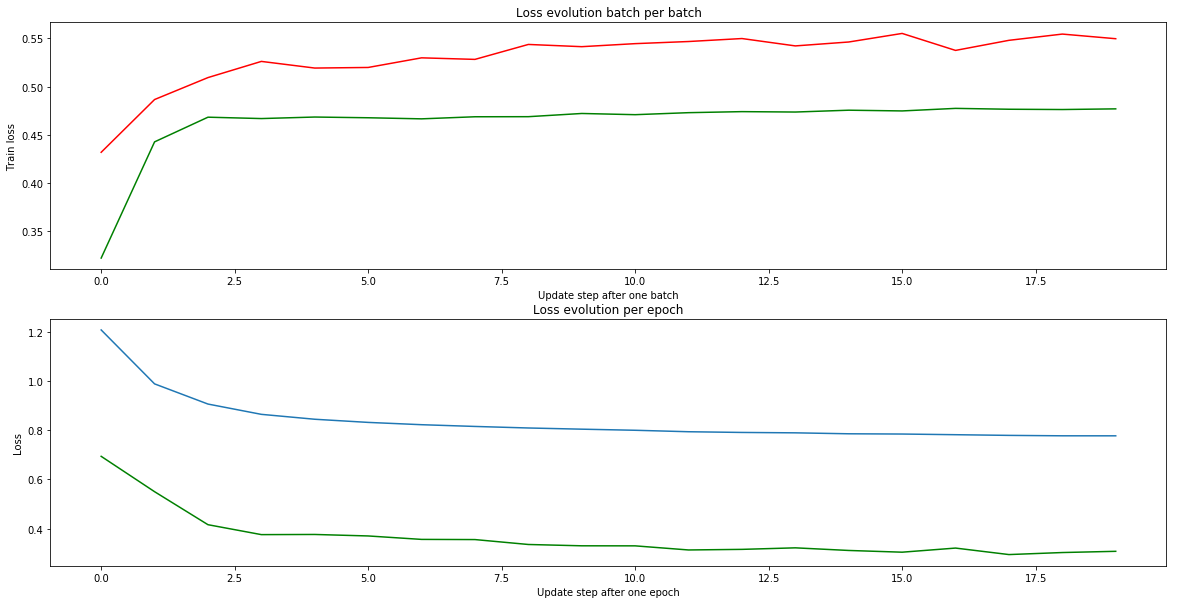

In [186]:

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history.history['f1'], color="Green")
ax[0].plot(history.history['val_f1'], color="Red")
ax[0].set_xlabel("Update step after one batch")
ax[0].set_ylabel("Train loss")
ax[0].set_title("Loss evolution batch per batch")
ax[1].plot(history.history["val_loss"], color="Green")
ax[1].plot(history.history["loss"])
ax[1].set_title("Loss evolution per epoch")
ax[1].set_xlabel("Update step after one epoch")
ax[1].set_ylabel("Loss")
fig.savefig("losses_improved_model", format="eps")

In [187]:
val_pred = model.predict(X_val)
val_pred

array([[0.12967141],
       [0.7106274 ],
       [0.12967141],
       ...,
       [0.4779887 ],
       [0.5893786 ],
       [0.48450047]], dtype=float32)

Text(0.5, 0, 'Predicted probabilites')

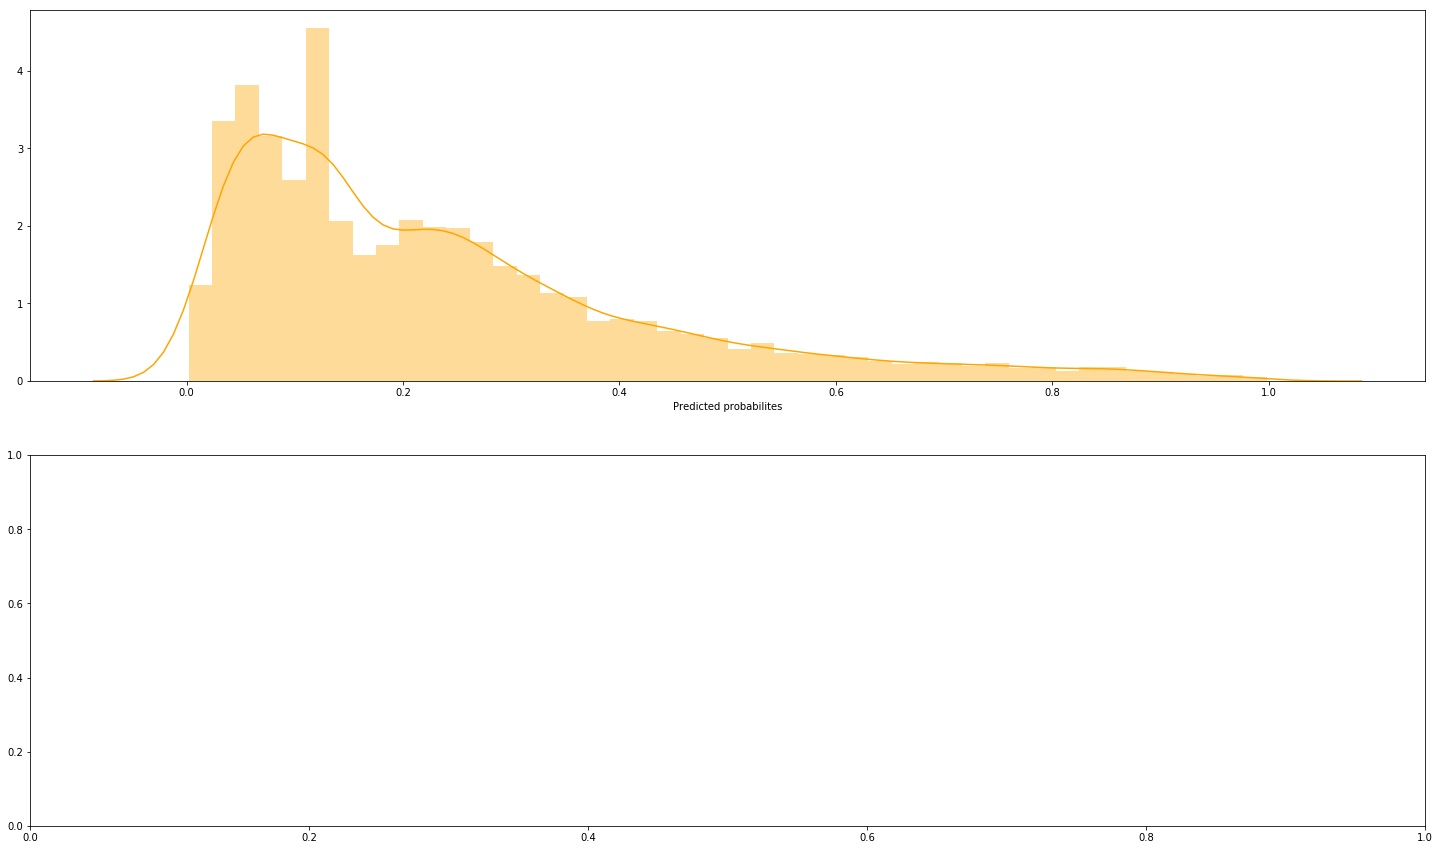

In [188]:
import seaborn as sns
fig, ax = plt.subplots(2,1,figsize=(25,15))
sns.distplot(val_pred, color="Orange", ax=ax[0])
ax[0].set_xlabel("Predicted probabilites")
# sns.distplot(improved_proba_predictions.values[:,1], color="Purple", ax=ax[1])
# ax[1].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[1]))
# ax[1]

In [149]:
roc_auc_score(y_val, val_pred)

0.8833649241663618

100%|██████████| 1000/1000 [00:03<00:00, 313.16it/s]


Probability threshold maximizing CV F1-score for each class:
[0.521] 0.7734606618167812


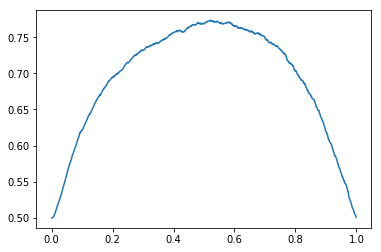

In [93]:
from tqdm import tqdm

rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0]))
for j,t in enumerate(tqdm(rng)):
    p = np.array(val_pred>t, dtype=np.int8)
    scoref1 = roc_auc_score(y_val, p)
    f1s[j] = scoref1

    
plt.plot(rng, f1s)
T = rng[np.where(f1s == np.max(f1s))[0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T, np.max(f1s))

Probability threshold maximizing CV F1-score for each class:
[0.398] 0.7632878103620613


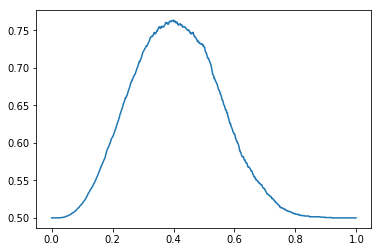

In [35]:
predictions = model.predict(test)

In [37]:
res=pandas.DataFrame({'ID_code':list(ID_code),'target':predictions.flatten()})

In [38]:
res.to_csv("answer_nn_pca1_features.csv",index=False)

In [39]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f answer_nn_pca1_features.csv -m " keras 2 layers 2 epoch weightd classes binary_crossentropy pca1 ext features 0.8824068103937862"

100%|███████████████████████████████████████| 4.25M/4.25M [00:08<00:00, 549kB/s]
Successfully submitted to Santander Customer Transaction Prediction